# Pomoćne funkcije

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy
import sklearn.preprocessing as pp
import sklearn.manifold as sm
import tensorflow as tf
from sklearn import metrics

In [ ]:
# Loading data, normalizing, and removing erroneous rows
def load(name, os_name, selection_fn):
    data = pd.read_csv(name)
    data_os = pd.read_csv(os_name)
    data = data.merge(data_os, left_on='osnovna_id', right_on='id', suffixes=(None, '_os'))
    data['dataset_name'] = name
    # Standardizing test scores and then scaling them to 0-5, to fit with the rest of the data (grades are 2-5)
    data['matematika'] = pp.MinMaxScaler(feature_range=(0, 5)).fit_transform(scipy.stats.zscore(data[['matematika']]))
    data['srpski'] = pp.MinMaxScaler(feature_range=(0, 5)).fit_transform(scipy.stats.zscore(data[['srpski']]))
    data['kombinovani'] = pp.MinMaxScaler(feature_range=(0, 5)).fit_transform(scipy.stats.zscore(data[['kombinovani']]))
    # Scaling student number (primary school size) to range 2-5; we'll be using MSE as error func in model,
    # so this makes more sense as grades are in 2-5 range
    data['broj_ucenika'] = pp.MinMaxScaler(feature_range=(2, 5)).fit_transform(data[['broj_ucenika']])
    # removing rows with missing or erronous data
    data = data[(data['likovno_p'] >= 2) & (data['tehnicko_p'] >= 2) & (data['geografija_p'] >= 2) &
                        (data['biologija_p'] >= 2) & (data['sport_p'] >= 2) & (data['drugi_strani_p'] >= 2) &
                        (data['matematika_p'] >= 2) & (data['istorija_p'] >= 2) & (data['engleski_p'] >= 2) &
                        (data['muzicko_p'] >= 2) & (data['fizicko_p'] >= 2) & (data['vladanje_p'] >= 2) &
                        (data['fizika_p'] >= 2) & (data['srpski_p'] >= 2) & (data['hemija_p'] >= 2)]
    return data, selection_fn(data)

In [ ]:
# Various selection functions, to be passed as selection_fn to load function

def select_features_p(df):
    return pd.DataFrame(df[['likovno_p', 'tehnicko_p', 'geografija_p', 'biologija_p', 'sport_p', 'drugi_strani_p',
                                'matematika_p', 'istorija_p', 'engleski_p', 'muzicko_p', 'fizicko_p', 'vladanje_p',
                                'fizika_p', 'srpski_p', 'hemija_p', 'matematika', 'srpski', 'kombinovani']])


# this one proved to be most useful (the rest perform worse)
def select_features_p_os(df):
    return pd.DataFrame(
        df[['likovno_p', 'tehnicko_p', 'geografija_p', 'biologija_p', 'sport_p', 'drugi_strani_p',
            'matematika_p', 'istorija_p', 'engleski_p', 'muzicko_p', 'fizicko_p', 'vladanje_p',
            'fizika_p', 'srpski_p', 'hemija_p', 'broj_ucenika', 'matematika', 'srpski', 'kombinovani']])
    # encoding location data (e.g. okrug) is a bit tricky and it actually worsened the model,
    # so it was removed


def select_features_78(df):
    return pd.DataFrame(df[['likovno7', 'tehnicko7', 'geografija7', 'biologija7', 'sport7', 'drugi_strani7',
                                'matematika7', 'istorija7', 'engleski7', 'muzicko7', 'fizicko7',
                                'fizika7', 'srpski7', 'hemija7',
                                'likovno8', 'tehnicko8', 'geografija8', 'biologija8', 'sport8', 'drugi_strani8',
                                'matematika8', 'istorija8', 'engleski8', 'muzicko8', 'fizicko8',
                                'fizika8', 'srpski8', 'hemija8',
                                'matematika', 'srpski', 'kombinovani']])

In [ ]:
# A quick way to do tSNE and plot the results, for sanity check purposes
def tsne_plot(df):
    print('calc tsne')
    tsne = sm.TSNE(n_jobs=8)
    res = tsne.fit_transform(df)
    print('done tsne')
    sns.scatterplot(x=res[:, 0], y=res[:, 1])
    plt.show()

In [ ]:
# Build autoencoder model
def build_model(input_dim):
    autoencoder = tf.keras.models.Sequential([
        tf.keras.layers.Dense(input_dim, activation='selu', input_shape=(input_dim,)),
        tf.keras.layers.Dense(8, activation='selu'),

        tf.keras.layers.Dense(4, activation='selu'),

        tf.keras.layers.Dense(8, activation='selu'),
        tf.keras.layers.Dense(input_dim, activation='selu'),
    ])
    # selu was chosen by trial-and-error
    # autoencoder structure was also determined by trial-and-error: making the latent
    # dimension lower results in worse performance; making model contain more layers
    # also didn't work well, this is the best we found so far
    # also, we don't particulary here about making encoder and decoder different here,
    # as we'll be using autoencoder as a whole all the time
    autoencoder.compile(optimizer="adam",
                        loss="mse",
                        metrics=["acc"])
    autoencoder.summary()
    return autoencoder

In [ ]:
# Train model with early stopping
def train_model(autoencoder, features):
    BATCH_SIZE = 512
    EPOCHS = 200  # in practice, this is rarely (never?) reached due to early stopping
    early_stop = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        min_delta=0.0001,
        patience=10,
        verbose=1,
        mode='min',
        restore_best_weights=True
    )

    save_model = tf.keras.callbacks.ModelCheckpoint(
        filepath='autoencoder_best_weights.hdf5',
        save_best_only=True,
        monitor='val_loss',
        verbose=0,
        mode='min'
    )

    history = autoencoder.fit(
        features, features,
        shuffle=True,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        callbacks=[early_stop, save_model],
        validation_split=0.2  # take any 20% as model validation data
        # (for examining outlier detection, we'll use never before seen data)
    )
    return history

In [ ]:
# get a proportion of a whole dataset for which autoencoder errs the most
# this is a fairly simple method, not taking into account actual error values
def get_outliers(data, features, autoencoder, proportion):
    predictions = autoencoder.predict(features)
    print('total error: ', metrics.mean_squared_error(features, predictions))

    features_arr = np.array(features)
    preds_arr = np.array(predictions)
    # calculating MSE using np (as sklearn's mse doesn't support axis argument)
    errors = np.mean((features_arr - preds_arr) ** 2, axis=1)
    errors_df = pd.DataFrame(errors, columns=['errors'])
    data_errors = data.join(errors_df)
    return data_errors.nlargest(int(proportion * len(data_errors)), 'errors')

In [ ]:
# Functions to calculate and print some metrics which should intuitively be
# different for outliers
def calc_simple_metrics(df):
    matematika_score = (df['matematika'] / df['matematika_p'])
    print('Matematika score: ', matematika_score.mean(), ' sd ', matematika_score.std())
    srpski_score = (df['srpski'] / df['srpski_p'])
    print('Srpski score: ', srpski_score.mean(), ' sd ', srpski_score.std())
    kombinovani_score = (5 * df['kombinovani'] / (df['istorija_p'] + df['geografija_p'] + df['biologija_p'] +
                                                  df['fizika_p'] + df['hemija_p']))
    print('Kombinovani score: ', kombinovani_score.mean(), ' sd ', kombinovani_score.std())
    total_score = (5 * (df['matematika'] + df['srpski'] + df['matematika']) /
          (df['likovno_p'] + df['tehnicko_p'] + df['geografija_p'] + df['biologija_p'] + df['sport_p'] +
           df['drugi_strani_p'] + df['matematika_p'] + df['istorija_p'] + df['engleski_p'] + df['muzicko_p'] +
           df['fizicko_p'] + df['vladanje_p'] + df['fizika_p'] + df['srpski_p'] + df['hemija_p']))
    print('Total score: ', total_score.mean(), ' sd ', total_score.std())

    print('Broj ucenika score: ', df['broj_ucenika'].mean())

# VAE stuff

Jedna od ideja je bila i treniranje varijacionog autoenkodera. Ovo se nije pokazalo previše korisnim, ali ostavljamo implementaciju enkodera ovde.

In [ ]:
import tensorflow as tf
from tensorflow import keras

class Sampling(tf.keras.layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs, **kwargs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                    keras.losses.mse(data, reconstruction)
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }


def build_vae_models(input_dim):
    LATENT_DIM = 3
    inputs = tf.keras.Input(shape=(input_dim,))
    x = tf.keras.layers.Dense(12, activation='selu')(inputs)
    x = tf.keras.layers.Dense(8, activation='selu')(x)
    z_mean = tf.keras.layers.Dense(LATENT_DIM, name='z_mean')(x)
    z_var = tf.keras.layers.Dense(LATENT_DIM, name='z_log_var')(x)
    z = Sampling()([z_mean, z_var])
    encoder = tf.keras.Model(inputs, [z_mean, z_var, z], name="encoder")
    encoder.summary()

    inputs = tf.keras.layers.Input(shape=(LATENT_DIM, ))
    x = tf.keras.layers.Dense(12, activation='selu')(inputs)
    x = tf.keras.layers.Dense(8, activation='selu')(x)
    output = tf.keras.layers.Dense(input_dim, activation='selu')(x)
    decoder = tf.keras.Model(inputs, output, name="decoder")
    decoder.summary()

    return encoder, decoder

# Usage:
# (encoder, decoder) = build_vae_models(features.shape[1])
# vae = VAE(encoder, decoder)
# vae.compile(optimizer=keras.optimizers.Adam())
# vae.fit(features, epochs=100, batch_size=256)

# Izvršavanje

In [ ]:
# A sanity check: are there even outliers in this data?
# Load a single year...
(data2015, features2015) = load(
    'https://raw.githubusercontent.com/luka-j/UpisDbMigrator/master/csvdata/ucenici2015.csv',
    'https://raw.githubusercontent.com/luka-j/UpisDbMigrator/master/csvdata/os2015.csv',
    select_features_p_os)
# ... and visualize using tSNE
# tsne_plot(features2015)  # this one takes a while
# and it takes forever on colab, so commented it out. see image generated locally
# in the below box:

calc tsne


KeyboardInterrupt: ignored

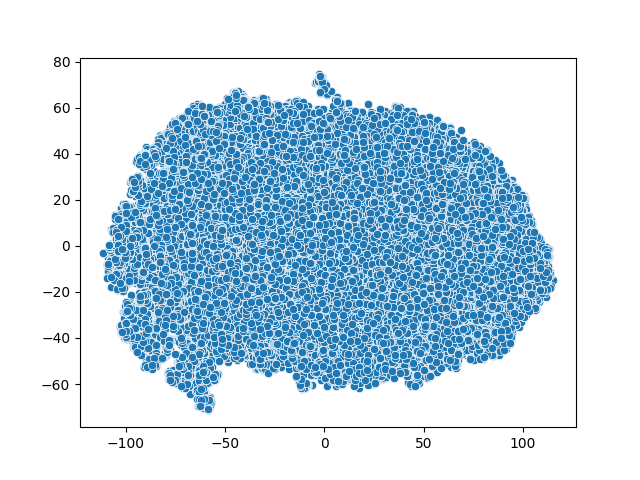

Deluje da ima nekih autlajera, na osnovu dva "repa" na prikazanoj sferi (dole levo i gore na sredini). Poređenja radi, ispod je tSNE plot za istu godinu, ali koji uključuje i redove sa nedostajućim podacima i greškama (load funkcija bez poslednjeg reda). Na njemu se vide značajnije deformacije, koje se smanjuju kada se izbace očigledne greške pri unosu, tako da je i ova jednostavna metoda dovoljna da uhvati neke štrčajuće podatke.

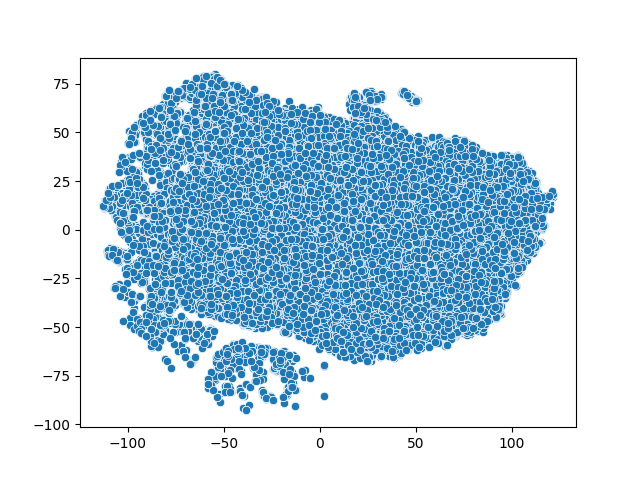

In [ ]:
# Loading the rest of the data and training the model
(data2016, features2016) = load(
    'https://raw.githubusercontent.com/luka-j/UpisDbMigrator/master/csvdata/ucenici2016.csv',
    'https://raw.githubusercontent.com/luka-j/UpisDbMigrator/master/csvdata/os2016.csv',
    select_features_p_os)
(data2017, features2017) = load(
    'https://raw.githubusercontent.com/luka-j/UpisDbMigrator/master/csvdata/ucenici2017.csv',
    'https://raw.githubusercontent.com/luka-j/UpisDbMigrator/master/csvdata/os2017.csv',
    select_features_p_os)
(data2018, features2018) = load(
    'https://raw.githubusercontent.com/luka-j/UpisDbMigrator/master/csvdata/ucenici2018.csv',
    'https://raw.githubusercontent.com/luka-j/UpisDbMigrator/master/csvdata/os2018.csv',
    select_features_p_os)
(data2019, features2019) = load(
    'https://raw.githubusercontent.com/luka-j/UpisDbMigrator/master/csvdata/ucenici2019.csv',
    'https://raw.githubusercontent.com/luka-j/UpisDbMigrator/master/csvdata/os2019.csv',
    select_features_p_os)

data = pd.concat([data2015, data2016, data2017, data2018, data2019])
features = pd.concat([features2015, features2016, features2017, features2018, features2019])
autoencoder = build_model(features.shape[1])
history = train_model(autoencoder, features)
# alternatively, load existing weights:
# autoencoder.load_weights('autoencoder_best_weights.hdf5')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 19)                380       
                                                                 
 dense_1 (Dense)             (None, 8)                 160       
                                                                 
 dense_2 (Dense)             (None, 4)                 36        
                                                                 
 dense_3 (Dense)             (None, 8)                 40        
                                                                 
 dense_4 (Dense)             (None, 19)                171       
                                                                 
Total params: 787
Trainable params: 787
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
513/513 [==============================] - 5s 

Veća količina podataka ne popravlja značajno model: recimo, kada se trenira samo na podacima iz 2015 i 2016, validation loss je 0.1477, što je u rangu dobijenog i kada se uzmu podaci 2015-2019. S druge strane, sa manje podataka, model se brže trenira i dostiže early stopping uslov dosta ranije.

U toku isprobavanja i štelovanja, korišćeni su podaci 2015-2019 (u startu samo 2015, posle je proširivano). Taj deo izostavljamo u colabu, jer se konceptualno ne razlikuje od ovoga što sledi (a i PyCharm je korišćen kao scrachpad, tako da taj kod mahom nije sačuvan).

Jedini potencijalno zanimljiv zaključak je da ako se koristi load funkcija koja ne dropuje redove sa izostajućim podacima, greška modela je veća, a ti redovi ubedljivo najviše doprinose grešci, što je upravo i ono što bismo očekivali.

In [ ]:
# Let's see how the model is actually performing, on a never before seen data
# (tuning everything so far was done on a few existing years; omitting all debugging
#  and evaluation of these metrics on 2015-2019 data for brevity)
(data2020, features2020) = load(
    'https://raw.githubusercontent.com/luka-j/UpisDbMigrator/master/csvdata/ucenici2020.csv',
    'https://raw.githubusercontent.com/luka-j/UpisDbMigrator/master/csvdata/os2020.csv',
    select_features_p_os)
outliers = get_outliers(data2020, features2020, autoencoder, 0.004)  # ovo je ~250 učenika
non_outliers = pd.concat([data, outliers]).drop_duplicates(keep=False)
print('Non outlier metrics: ')
calc_simple_metrics(non_outliers)
print('Outlier metrics: ')
calc_simple_metrics(outliers)

1977/1977 [==============================] - 3s 1ms/step
total error:  0.13891719933484933
Non outlier metrics: 
Matematika score:  0.7832733012015802  sd  0.29745595311932604
Srpski score:  0.8960598311073091  sd  0.2698723829713666
Kombinovani score:  0.884141180714821  sd  0.28773088907922334
Total score:  0.6786430899551025  sd  0.1980786187204805
Broj ucenika score:  3.028700230850318
Outlier metrics: 
Matematika score:  0.897726188918791  sd  0.27983495142766185
Srpski score:  0.8186831580645357  sd  0.22867917749743513
Kombinovani score:  1.0037919868459988  sd  0.28750808110040366
Total score:  0.7147853570067911  sd  0.16108837317534797
Broj ucenika score:  2.9673184863298934


Razlike među autlajerima i ostalim učenicima su nešto manje nego očekivane kada se pogledaju odnosi bodova na završnom i ocena u školi, ali ipak se može uočiti da su autlajeri uradili završni ispit iz matematike i kombinovani (u odnosu na ocene iz relevantnih predmeta) bolje nego tipične instance. Zanimljivo je da je situacija za srpski jezik obrnuta, ali i da je razlika manja. Donekle je neočekivano da su standardne devijacije slične između rezultata autlajera i onih koji to nisu: ovo nam govori da autlajeri ne idu "u obe strane", već su "pomereni" na jednu stranu u odnosu na tipične instance.

Takođe, deluje da su autlajeri iz nešto manjih škola, ali ova razlika ne izgleda veliko.

Ovo bi mogao da bude indikator da se češće vara na završnom ispitu iz matematike i kombinovanom, ili da su ocene na ovim predmetima dovoljno nekonzistentne da ne koreliraju sa ocenama na završnom na nivou države. Međutim, da bismo mogli da tvrdimo da razlika postoji, potrebna je detaljnija statistička analiza da utvrdi značaj ovih razlika, a zatim i da ih protumači.

Za kraj, pogledajmo raspodelu autlajera u odnosu na okruge:

In [ ]:
nol_okr = non_outliers['okrug'].value_counts() / len(non_outliers)
ol_okr = outliers['okrug'].value_counts() / len(outliers)

okr_scores = pd.DataFrame(ol_okr / nol_okr).sort_values(by='okrug', ascending=False)
print(okr_scores)

                       okrug
pirotski            2.465308
kosovskopomoravski  2.028158
branicevski         1.922737
raski               1.289664
podunavski          1.268284
pomoravski          1.258215
juznobacki          1.244375
zajecarski          1.193854
macvanski           1.127323
gradbeograd         1.061817
sumadijski          1.057158
zapadnobacki        0.988813
severnobacki        0.981736
sremski             0.933848
jablanicki          0.887319
toplicki            0.879873
nisavski            0.873705
kolubarski          0.866763
zlatiborski         0.862974
borski              0.820414
moravicki           0.783343
srednjebanatski     0.671350
pcinjski            0.600116
juznobanatski       0.499230
kosovskomitrovacki  0.482984
severnobanatski     0.450507
rasinski            0.360136
kosovski                 NaN
pecki                    NaN
prizrenski               NaN


Odavde se vidi da su autlajeri skoro 2.5 puta zastupljeniji u Pirotskom okrugu nego što bismo očekivali, i više nego duplo zastupljeniji u Kosovsko-pomoravskom okrugu. Ovo nije preterano iznenađujuće, ali svakako je vredno pomena: autlajeri nisu geografski uniformno raspoređeni, već se češće javljaju u određenim delovima države.

Prikazani autoenkoder daje rezultate koji se donekle poklapaju sa intuitivnim shvatanjem "autlajera" u kontekstu rezultata završnog ispita, mada se verovatno ne može koristiti da bi se izvukli zaključci o pojedinačnim instancama. Da bismo pričali o značajnosti samih rezultata, potrebna je rigoriznija statistička analiza.

Iako je na osnovu ovog rada teško izvući konkretne zaključke, on pruža još jedan (za sada dosta grub) alat koji se može koristiti za detekciju sumnjivih instanci u rezultatima završnog ispita i može ukazati na neke trendove na nivou celog sistema.